In [11]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
import stable_baselines3
import time
from utils import set_size
from utils import linestyle_tuple
from utils import load_csv
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
import pde_control_gym
from pde_control_gym.src import TunedReward1D
#plt.rcParams['text.usetex'] =True
# 可选，根据需要添加 LaTeX 宏包
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [12]:
# Print Versioning
print("Gym version", gym.__version__)
print("Numpy version", np.__version__)
print("Stable Baselines3 version", stable_baselines3.__version__)

Gym version 0.29.1
Numpy version 2.2.4
Stable Baselines3 version 2.2.1


This Jupyter-notebook has an adjoining tutorial at https://pdecontrolgym.readthedocs.io/en/latest/guide/tutorials.html

Action sent: -0.19131170411260512
Action sent: -0.3184314025615565
Action sent: -0.39248990067638645
Action sent: -0.4607695603434678
Action sent: -0.5253698337736701
Action sent: -0.5862836763776633
Action sent: -0.6434173585856618
Action sent: -0.6966855219870572
Action sent: -0.7460153884635952
Action sent: -0.7913467485377792
Action sent: -0.8326320620996015
Action sent: -0.8698362351854176
Action sent: -0.9029368776872275
Action sent: -0.9319234852949204
Action sent: -0.9567977476113266
Action sent: -0.9775729700808087
Action sent: -0.99427449484296
Action sent: -1.0069387454508107
Action sent: -1.015613194789121
Action sent: -1.020356276985486
Action sent: -1.0212367478334268
Action sent: -1.0183334551724645
Action sent: -1.0117350721722074
Action sent: -1.0015396734372795
Action sent: -0.9878541939289883
Action sent: -0.9707942929262103
Action sent: -0.9504835776530893
Action sent: -0.9270535016833885
Action sent: -0.9006424262208882
Action sent: -0.8713957039996065
Action sent:

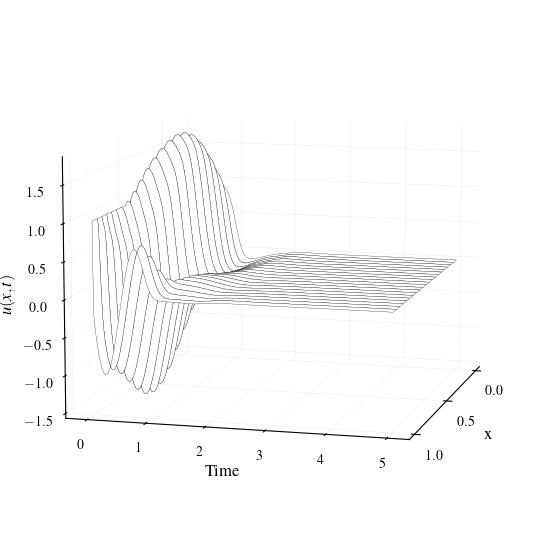

In [13]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 假设 TunedReward1D 是从某个地方导入的
from pde_control_gym.src.rewards import TunedReward1D  # 请根据实际情况修改导入路径

# 以下函数与 1.py 中的函数保持一致
def solveBetaFunction(x, gamma):
    beta = np.zeros(len(x), dtype=np.float32)
    for idx, val in enumerate(x):
        beta[idx] = 5 * np.cos(gamma * np.arccos(val))  # 修正：使用 np 而不是 math
    return beta

def getInitialCondition(nx):
    return (np.ones(nx)*1)#np.random.uniform(1, 10))

# NO NOISE
def noiseFunc(state):
    return state

# Kernel function solver for backstepping
def solveKernelFunction(theta):
    kappa = np.zeros(len(theta))
    for i in range(0, len(theta)):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*theta[j])*dx
        kappa[i] = kernelIntegral - theta[i]
    return np.flip(kappa)

# Control convolution solver
def solveControl(kernel, u):
    res = 0
    for i in range(len(u)):
        res += kernel[i]*u[i]
    return res*1e-2

# 修改后的 getBetaFunction
def getBetaFunction(nx,lamArr):
    
    return solveBetaFunction(np.linspace(0, 1, nx), lamArr)

# Timestep and spatial step for PDE Solver
T = 5
dt = 1e-4
dx = 0.01
X = 1
lamArr=6
hyperbolicParameters = {
    "T": T,
    "dt": dt,
    "X": X,
    "dx": dx,
    "lamArr":lamArr,
    "reward_class": TunedReward1D(int(round(T / dt)), -1e3, 3e2),
    "normalize": False,
    "sensing_loc": "full",
    "control_type": "Dirchilet",
    "sensing_type": None,
    "sensing_noise_func": lambda state: state,
    "limit_pde_state_size": True,
    "max_state_value": 1e10,
    "max_control_value": 20,
    "reset_init_condition_func": getInitialCondition,
    "reset_recirculation_func": getBetaFunction,  # 使用修改后的函数
    "control_sample_rate": 0.01,
}

# Make the hyperbolic PDE gym
env = gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParameters)

# Run a single environment test case for gamma=8
terminate = False
truncate = False
nt = int(round(X / dx))+1
x = np.linspace(0, 1, nt + 1)

# Holds the resulting states
uStorage = []

# Reset Environment
obs, __ = env.reset()

uStorage.append(obs[101:])

spatial = np.linspace(dx, X, int(round(X / dx) + 1))
kernel = solveKernelFunction(solveBetaFunction(spatial, lamArr))
i = 0
rew = 0



while not truncate and not terminate:
    # use backstepping controller
    action = solveControl(kernel, obs[101:])
    print(f"Action sent: {action}")  # 新增打印
    obs, rewards, terminate, truncate, info = env.step(action)

    uStorage.append(obs[101:])
    rew += rewards
    
u = np.array(uStorage)
print(f"x_train形状: {u.shape}") 
print("Total Reward", rew)

# Plot the example
res = 1
fig = plt.figure()
spatial = np.linspace(0, X, int(round(X / dx) + 1))
temporal = np.linspace(0, T, len(uStorage))
u = np.array(uStorage)

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

meshx, mesht = np.meshgrid(spatial, temporal)

axes.plot_surface(meshx, mesht, u, edgecolor="black", lw=0.2, rstride=500, cstride=5,
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$u(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
plt.show()

成功加载Branch网络权重: 6个参数
成功加载Trunk网络权重: 6个参数
成功加载Branch网络权重: 6个参数
成功加载Trunk网络权重: 6个参数
成功加载Branch网络权重: 6个参数
成功加载Trunk网络权重: 6个参数
原始SAC平均奖励: 362.27
原始SAC平均L2范数和: 2869.68
第一个SAC平均奖励: 375.49
第一个SAC平均L2范数和: 1690.81
DeepONet SAC平均奖励: 366.60
DeepONet SAC平均L2范数和: 2661.41


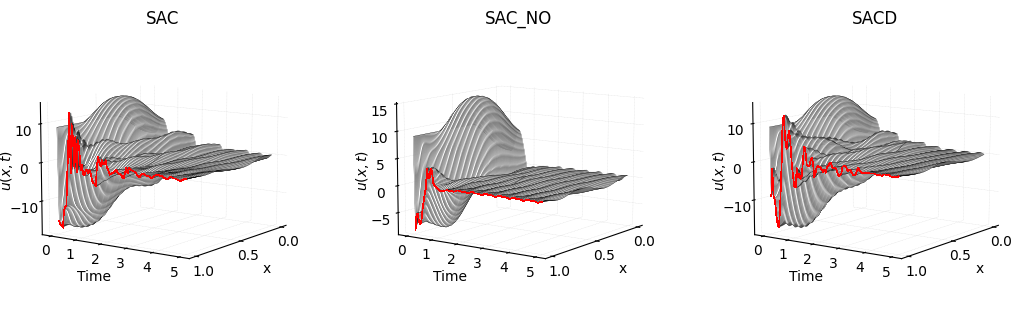

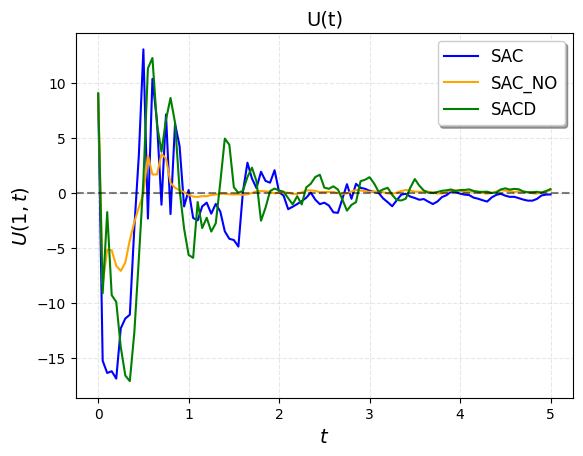

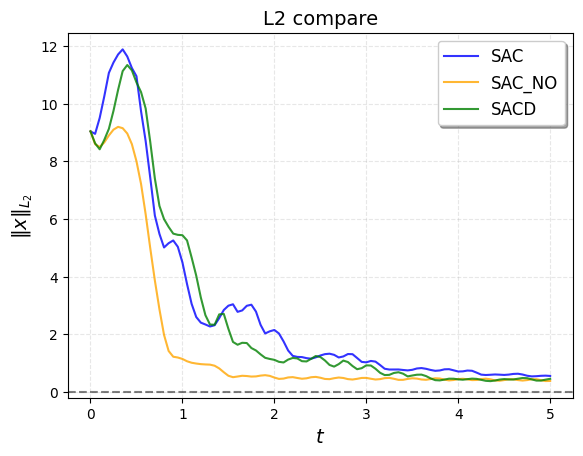

In [ ]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
import pde_control_gym
from pde_control_gym.src import TunedReward1D
from pathlib import Path

# ==============================
# 辅助函数定义（完整保留）
# ==============================
def solveBetaFunction(x, gamma):
    beta = np.zeros(len(x), dtype=np.float32)
    for idx, val in enumerate(x):
        beta[idx] = 5 * math.cos(gamma * math.acos(val))
    return beta

def solveKernelFunction(beta):
    k = np.zeros((len(beta), len(beta)))
    a = beta
    dx = 0.01  # 假设与全局dx一致，需根据实际情况调整
    k[1][1] = -(a[1] + a[0]) * dx / 4
    for i in range(1, len(beta) - 1):
        k[i + 1][0] = 0
        k[i + 1][i + 1] = k[i][i] - dx / 4.0 * (a[i - 1] + a[i])
        k[i + 1][i] = k[i][i] - dx / 2 * a[i]
        for j in range(1, i):
            k[i + 1][j] = -k[i - 1][j] + k[i][j + 1] + k[i][j - 1] + a[j] * (dx ** 2) * (k[i][j + 1] + k[i][j - 1]) / 2
    return k

def solveControl(kernel, u):
    dx = 0.01  # 假设与全局dx一致，需根据实际情况调整
    return sum(kernel[-1][0:len(u)] * u[0:len(u)]) * dx


# ==============================
# 全局参数配置（完整保留）
# ==============================
T = 5
dt = 1e-3
dx = 0.01
X = 1
hyperbolicParameters = {
    "T": T,
    "dt": dt,
    "X": 1,
    "dx": dx,
    "lamArr":6.7,
    "reward_class": TunedReward1D(int(round(T / dt)), -1e3, 3e2),
    "normalize": True,
    "sensing_loc": "full",
    "control_type": "Dirchilet",
    "sensing_type": None,
    "sensing_noise_func": lambda state: state,
    "limit_pde_state_size": True,
    "max_state_value": 1e10,
    "max_control_value": 20,
    "reset_init_condition_func": lambda nx: np.ones(nx ) *9,  # np.random.uniform(1, 10),
    "reset_recirculation_func": lambda nx, lamArr: np.array([5 * math.cos(lamArr * math.acos(val)) for val in np.linspace(0, 1, nx )]),
    "control_sample_rate": 0.05,
}

# ==============================
# 单episode运行函数（完整保留）
# ==============================
def runSingleEpisode(model, env, parameter):
    terminate = False
    truncate = False
    uStorage = []
    u_at_x = []
    Reward = []
    obs, _ = env.reset()
    uStorage.append(obs[101:])
    u_at_x.append(obs[-1])
    i = 0
    rew = 0
    while not truncate and not terminate:
        action = model(obs, parameter)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs[101:])
        u_at_x.append(obs[-1])
        Reward.append(rewards)
        rew += rewards
    u = np.array(uStorage)
    u_at_x1 = np.array(u_at_x)
    reward = np.array(Reward)
    l2_norm_sum = np.sum([np.linalg.norm(state) for state in u])
    return rew, u, u_at_x1, l2_norm_sum, reward

# ==============================
# RL控制器函数（完整保留）
# ==============================
def RLController(obs, model):
    action, _state = model.predict(obs, deterministic=True)
    return action

# ==============================
# 环境初始化（完整保留）
# ==============================
hyperbolicParametersRL = hyperbolicParameters.copy()
hyperbolicParametersRL["normalize"] = True
envRL = gym.make("PDEControlGym-TransportPDE1D", **hyperbolicParameters)


# ==============================
# 模型加载路径（完整保留+新增）
# ==============================
sacModelPath ="./logsh99/experiment2/seed_42/sac_model_ronet_100000_steps"
sacModel = SAC.load(sacModelPath)
sacModelPath1 = "./logsh55/experiment1/seed_42/final_model.zip"
sacModel1 = SAC.load(sacModelPath1)

sacModelPathD = "./logsh55_deeponet/experiment3/seed_43/sac_model_deeponet_100000_steps"
sacModelD = SAC.load(sacModelPathD)

# ==============================
# 模型测试与数据收集（完整保留+新增）
# ==============================
num_instances = 5  # 可根据需求调整测试次数

# 1. 原始SAC模型 (sacModel)
data_original = {"rew": 0, "u": None, "u_at_x": None, "l2_sum": 0}
for i in range(num_instances):
    rew, u, u_at_x, l2_sum, _ = runSingleEpisode(RLController, envRL, sacModel1)
    data_original["rew"] += rew
    data_original["u"] = u
    data_original["u_at_x"] = u_at_x
    data_original["l2_sum"] += l2_sum
print(f"原始SAC平均奖励: {data_original['rew']/num_instances:.2f}")
print(f"原始SAC平均L2范数和: {data_original['l2_sum']/num_instances:.2f}")

# 2. 第一个SAC模型 (sacModel1)
data_first = {"rew": 0, "u": None, "u_at_x": None, "l2_sum": 0}
for i in range(num_instances):
    rew, u, u_at_x, l2_sum, _ = runSingleEpisode(RLController, envRL, sacModel)
    data_first["rew"] += rew
    data_first["u"] = u
    data_first["u_at_x"] = u_at_x
    data_first["l2_sum"] += l2_sum
print(f"第一个SAC平均奖励: {data_first['rew']/num_instances:.2f}")
print(f"第一个SAC平均L2范数和: {data_first['l2_sum']/num_instances:.2f}")

# 3. 新增: DeepONet SAC模型 (sacModelD)
data_deeponet = {"rew": 0, "u": None, "u_at_x": None, "l2_sum": 0}
for i in range(num_instances):
    rew, u, u_at_x, l2_sum, _ = runSingleEpisode(RLController, envRL, sacModelD)
    data_deeponet["rew"] += rew
    data_deeponet["u"] = u
    data_deeponet["u_at_x"] = u_at_x
    data_deeponet["l2_sum"] += l2_sum
print(f"DeepONet SAC平均奖励: {data_deeponet['rew']/num_instances:.2f}")
print(f"DeepONet SAC平均L2范数和: {data_deeponet['l2_sum']/num_instances:.2f}")

# ==============================
# 图形尺寸辅助函数（若未定义需添加）
# ==============================
def set_size(width, fraction=1, ncols=1, nrows=1, height_add=0):
    inches_per_pt = 1 / 72.27
    fig_width = width * inches_per_pt * fraction
    fig_height = fig_width * 0.618 * (nrows / ncols) + height_add  
    return (fig_width, fig_height)


# ==============================
# 3D状态场对比绘图（最小改动优化）
# ==============================
fig = plt.figure(figsize=set_size(800, 0.99, ncols=3, nrows=1, height_add=2))  # 增大画布宽度，让子图更宽松
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)  # 简化为 1 行 1 列主图，避免多层嵌套拥挤

subfig = subfigs
#subfig.suptitle(r"Example trajectories for $\lambda=6.7$ with SAC, SAC_NO, and SACD", fontsize=14)
# 增大子图间距，避免挤压
subfig.subplots_adjust(left=0.05, bottom=0.08, right=0.95, top=0.9, wspace=0.3, hspace=0.3)  
X = 1
dx = 1e-2
T = 5
spatial = np.linspace(dx, X, int(round(X/dx)+1))
temporal = np.linspace(0, T, len(data_original["u"]))
meshx, mesht = np.meshgrid(spatial, temporal)

# 改为 1 行 3 列子图，直接在 subfig 上创建
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})

for axes in ax:
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1,1,1))

# 遍历子图，设置标题、绘制内容
model_titles = ["SAC", "NOSAC_training", "NOSAC"]  # 按 data_original、data_first、data_deeponet 对应关系调整
for i, data in enumerate([data_original, data_first, data_deeponet]):
    ax[i].view_init(10, 35)
    ax[i].set_xlabel("x", labelpad=-3)
    ax[i].set_ylabel("Time", labelpad=-3)
    ax[i].set_zlabel(r"$u(x, t)$", rotation=90, labelpad=-7)
    ax[i].zaxis.set_rotate_label(False)
    ax[i].set_xticks([0, 0.5, 1])
    ax[i].tick_params(axis='x', which='major', pad=-3)
    ax[i].tick_params(axis='y', which='major', pad=-3)
    ax[i].tick_params(axis='z', which='major', pad=-1)
    ax[i].set_title(model_titles[i], fontsize=12)  # 添加子图标题
    
    # 绘制 3D 表面
    ax[i].plot_surface(meshx, mesht, data["u"], edgecolor="black",lw=0.2, rstride=50, cstride=1, 
                       alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # 绘制红线（适当增大线宽到 0.5 ，更清晰）
    test = np.ones(len(temporal))
    vals = (data["u"].transpose())[-1] 
    ax[i].plot(test[1:], temporal[1:], vals[1:], color="red", lw=0.5, antialiased=False, rasterized=False)

plt.show()
def set_size(width, fraction=1, ncols=1, nrows=1, height_add=0):
    inches_per_pt = 1 / 72.27
    fig_width = width * inches_per_pt * fraction
    fig_height = fig_width * 0.618 * (nrows / ncols) + height_add  # nrows和ncols必须为整数
    return (fig_width, fig_height)

# 调用时传递整数参数 ncols=1, nrows=1
fig, ax = plt.subplots(figsize=set_size(433, 0.99, ncols=1, nrows=1, height_add=1))
ax.plot(temporal, data_original["u_at_x"], label='SAC', color='blue', linewidth=1.5)
ax.plot(temporal, data_first["u_at_x"], label='NOSAC_training', color='orange', linewidth=1.5)
ax.plot(temporal, data_deeponet["u_at_x"], label='NOSAC', color='green', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel(r'$t$', fontsize=14)
ax.set_ylabel(r'$U(1, t)$', fontsize=14)
ax.legend(fontsize=12, frameon=True, shadow=True)
ax.grid(True, linestyle='--', alpha=0.3)
plt.title('U(t)', fontsize=14)
plt.tight_layout()
plt.show()

# ==============================
# L2范数对比绘图（完整扩展）
# ==============================
def compute_l2_norm(u, dx):
    return np.sqrt(np.sum(u**2, axis=1) * dx)

l2_original = compute_l2_norm(data_original["u"], dx)
l2_first = compute_l2_norm(data_first["u"], dx)
l2_deeponet = compute_l2_norm(data_deeponet["u"], dx)

# 明确传递 ncols=1（整数）
plt.figure(figsize=set_size(433, 0.99, ncols=1, height_add=1)) 
plt.plot(temporal, l2_original, label='SAC', color='blue', linewidth=1.5, alpha=0.8)
plt.plot(temporal, l2_first, label='NOSAC_training', color='orange', linewidth=1.5, alpha=0.8)
plt.plot(temporal, l2_deeponet, label='NOSAC', color='green', linewidth=1.5, alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$\|x\|_{L_2}$', fontsize=14)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.title('L2 compare', fontsize=14)
plt.tight_layout()
plt.show()